In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import figure,show
from bokeh.io import output_notebook
from scipy.signal import butter, lfilter, freqz
import pywt
output_notebook()

Loading BokehJS ...

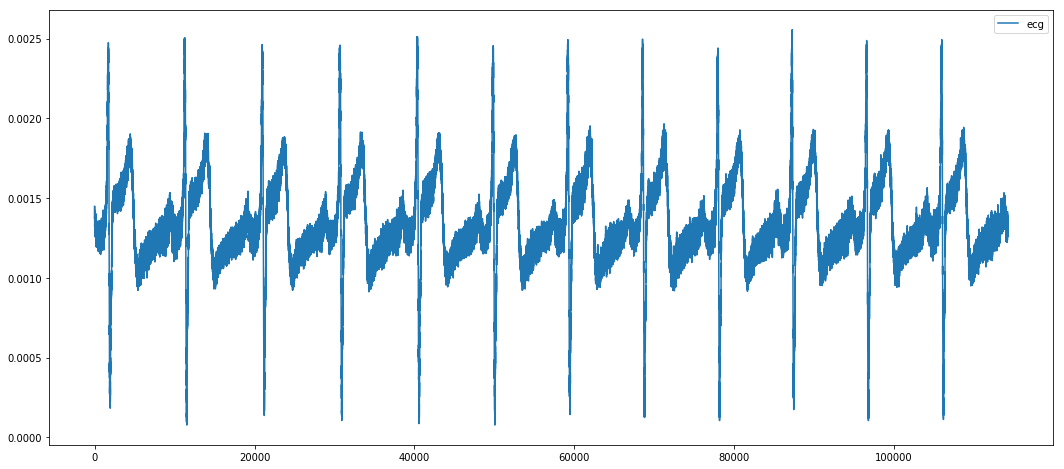

In [2]:
df = pd.read_csv('ECG.txt', names=['ecg'])
df.plot(figsize=(18,8))
plt.show()

In [3]:
class ecg():
    def __init__(self, df, sample_rate=10000, hr_max=200):
        self.df = df
        self.ecg = df['ecg']
        self.sample_rate = sample_rate
        self.hr_max = hr_max
    
    def butter_lowpass(self, cutoff, fs, order=5):
        nyq = 0.5 * fs
        normal_cutoff = cutoff/nyq
        b,a = butter(order, normal_cutoff, btype='low',analog=False)
        return b, a
    
    def butter_lowpass_filter(self, data, cutoff, fs, order=5):
        b,a = self.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b,a, data)
        return y
    
    def detect_qrs(self,sample_rate=10000, max_bpm=200):
        filtered_ecg = self.butter_lowpass_filter(self.ecg, cutoff=3.667, fs=1000.0, order=5)
        (c1,c2),(c3,c4) = pywt.swt(filtered_ecg, 'db1', level=2, start_level=0, axis=-1)
        avg,std = np.mean(c2),np.std(c2)
        sig_thres = [abs(x) if abs(x)>2.0*std else 0 for x in c2-avg]
        
        window = int((60.0/max_bpm)*sample_rate)
        sig_len = len(filtered_ecg)
        n_windows = int(sig_len/window)
        modulus,qrs = [],[]
        
        for x in range(n_windows):
            start = window*x
            end = min([(x+1)*window,sig_len])
            mx = max(sig_thres[start:end])
            if mx > 0:
                modulus.append((start + np.argmax(sig_thres[start:end]),mx))

        merge_width = int((0.2)*sample_rate)
        i=0
        while i < len(modulus)-1:
            ann = modulus[i][0]
            if modulus[i+1][0]-modulus[i][0] < merge_width:
                if modulus[i+1][1]>modulus[i][1]:
                    ann = modulus[i+1][0]
                i+=1
            qrs.append(ann)
            i+=1

        window_check = int(sample_rate/6)
        r_peaks = [0]*len(qrs)

        for i,loc in enumerate(qrs):
            start = max(0,loc-window_check)
            end = min(sig_len,loc+window_check)
            wdw = np.absolute(filtered_ecg[start:end] - np.mean(filtered_ecg[start:end]))
            pk = np.argmax(wdw)
            r_peaks[i] = start+pk
        self.r_peaks = r_peaks
        return r_peaks
        
    def get_qrs(self):
        df['QRS'] = df.index.isin(ecg(df).detect_qrs())
        return df
        

In [4]:
df1 = ecg(df).get_qrs()

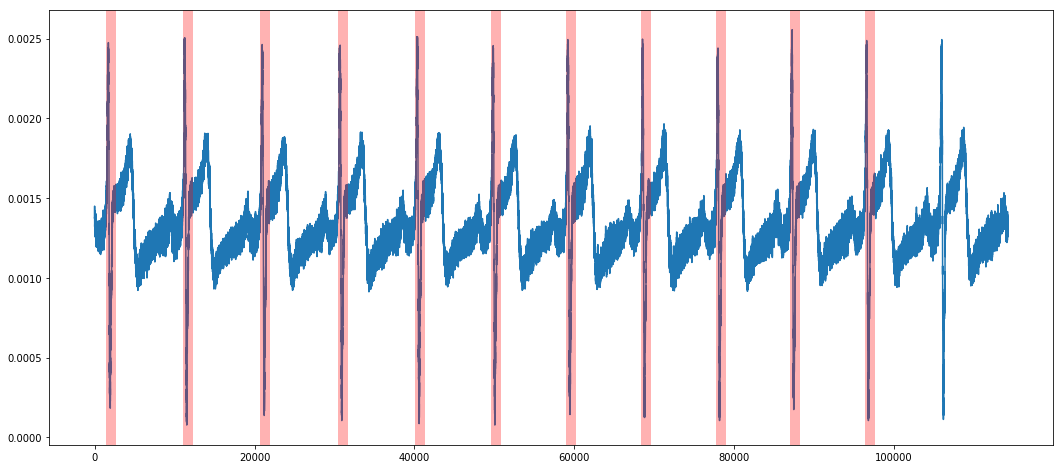

In [5]:
plt.figure(figsize=(18,8))
plt.plot(df1.index, df1.ecg)
for x in df1[df1.QRS == True].index:
    plt.axvline(x, alpha=0.3, color='r', linewidth=10,)

In [6]:
#RR
[(j-i)/10000 for i,j in zip(df1[df1['QRS']==True].index[:-1], df1[df1['QRS']==True].index[1:])]

[0.9587, 0.9696, 0.9706, 0.9666, 0.9478, 0.9376, 0.9339, 0.939, 0.9276, 0.933]